In [ ]:
%%bash
# Do not change or modify this file
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark

  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=d8bbff124efdfe2d53825c7b66303a79f95faca457e12d8fd8b4d169cb171741
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

MAX_MEMORY = "12g"

spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", MAX_MEMORY) \
  .config("spark.driver.memory", MAX_MEMORY)\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size",MAX_MEMORY)\
  .getOrCreate()

sc = spark.sparkContext

In [ ]:
from __future__ import division
from pyspark.sql import SparkSession
from pyspark.ml import clustering
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
import glob
import subprocess
import numpy as np
import pandas as pd
import os
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.sql import functions as fn
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os

In [ ]:
%%bash
pip install pyspark

if [[ ! -f ./train.csv ]]; then 
   wget https://raw.githubusercontent.com/aatishsuman/health-insurance-cross-sell-prediction/main/data/train.csv
fi

if [[ ! -f ./test.csv ]]; then 
   wget https://raw.githubusercontent.com/aatishsuman/health-insurance-cross-sell-prediction/main/data/test.csv  
fi

--2020-11-26 17:51:19--  https://raw.githubusercontent.com/aatishsuman/health-insurance-cross-sell-prediction/main/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21432357 (20M) [text/plain]
Saving to: ‘train.csv’

     0K .......... .......... .......... .......... ..........  0% 13.2M 2s
    50K .......... .......... .......... .......... ..........  0% 28.4M 1s
   100K .......... .......... .......... .......... ..........  0% 14.2M 1s
   150K .......... .......... .......... .......... ..........  0% 13.4M 1s
   200K .......... .......... .......... .......... ..........  1% 32.6M 1s
   250K .......... .......... .......... .......... ..........  1% 17.4M 1s
   300K .......... .......... .......... .......... ..........  1% 23.0M 1s
   350K ...

Load the train and test data into Spark Dataframes

In [ ]:
train = spark.read.format("csv").option("header", "true").load("train.csv")
test = spark.read.format("csv").option("header", "true").load("test.csv")

In [ ]:
train = train.drop('id')
test = test.drop('id')

Converting the numeric variables to double data type 

In [ ]:
train = train.withColumn("AgeTemp", train["Age"].cast("double")).drop("Age").withColumnRenamed("AgeTemp", "Age")
train = train.withColumn("DrivingTemp", train["Driving_License"].cast("double")).drop("Driving_License").withColumnRenamed("DrivingTemp", "Driving_License")
train = train.withColumn("Previously_InsuredTemp", train["Previously_Insured"].cast("double")).drop("Previously_Insured").withColumnRenamed("Previously_InsuredTemp", "Previously_Insured")
train = train.withColumn("Annual_PremiumTemp", train["Annual_Premium"].cast("double")).drop("Annual_Premium").withColumnRenamed("Annual_PremiumTemp", "Annual_Premium")
train = train.withColumn("Policy_Sales_ChannelTemp", train["Policy_Sales_Channel"].cast("double")).drop("Policy_Sales_Channel").withColumnRenamed("Policy_Sales_ChannelTemp", "Policy_Sales_Channel")
train = train.withColumn("VintageTemp", train["Vintage"].cast("double")).drop("Vintage").withColumnRenamed("VintageTemp", "Vintage")
train = train.withColumn("ResponseTemp", train["Response"].cast("double")).drop("Response").withColumnRenamed("ResponseTemp", "Response")

In [ ]:
train = train.withColumn("Region_CodeTemp", train["Region_Code"].cast("double")).drop("Region_Code").withColumnRenamed("Region_CodeTemp", "Region_Code")

In [ ]:
train = train.withColumn("ResponseTemp", train["Response"].cast("double")).drop("Response").withColumnRenamed("ResponseTemp", "Response")

Initial Modeling process:
1. Using string indexer to enode ordinal and nominal variables ( Gender, Vehicle age and Vehicle damage. Using quantile bucketizer for Vintage top bin the customers with 3 types of loyalty('new', 'medium', 'old') and bin age variable(0-35,35-65,>65). 
2. Using Oversampling technique to eradicate class imabalance. 
3. Fit base Logistic regression model on the Oversampled data frame. 
4. Crossvalidate for reguralisation parameters. 
5. Extract best hyperparameter values. 
6. Analyse the results. 

In [ ]:
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexerModel

gender_si = StringIndexerModel.from_labels(['Male', 'Female'],
                                    inputCol="Gender",
                                    outputCol="indexedGender")

Vehicle_Age_si = StringIndexerModel.from_labels(['< 1 Year','1-2 Year', '> 2 Years'],
                                    inputCol="Vehicle_Age",
                                    outputCol="indexedVehicle_Age")

Vehicle_Damage_si = StringIndexerModel.from_labels(['Yes', 'No'],
                                    inputCol="Vehicle_Damage",
                                    outputCol="indexedVehicle_Damage")

vintage_bin = feature.QuantileDiscretizer(inputCol='Vintage', outputCol='vintage_bin',numBuckets= 3)

age_bin = feature.Bucketizer(splits=[0, 35, 65, 100], inputCol='Age',outputCol= 'Age_bin')


feature_engineering_pipe = Pipeline(stages=[gender_si,Vehicle_Age_si,Vehicle_Damage_si,vintage_bin, age_bin, ])

train_xformed = feature_engineering_pipe.fit(train).transform(train).drop('Gender','Vehicle_Age','Vehicle_Damage','Vintage').withColumnRenamed("indexedGender",'Gender').withColumnRenamed("indexedVehicle_Age",'Vehicle_Age').withColumnRenamed("indexedVehicle_Damage",'Vehicle_Damage').withColumnRenamed('vintage_bin','Vintage')

train_xformed.show()

+----+---------------+------------------+--------------+--------------------+-----------+--------+------+-----------+--------------+-------+-------+
| Age|Driving_License|Previously_Insured|Annual_Premium|Policy_Sales_Channel|Region_Code|Response|Gender|Vehicle_Age|Vehicle_Damage|Vintage|Age_bin|
+----+---------------+------------------+--------------+--------------------+-----------+--------+------+-----------+--------------+-------+-------+
|44.0|            1.0|               0.0|       40454.0|                26.0|       28.0|     1.0|   0.0|        2.0|           0.0|    2.0|    1.0|
|76.0|            1.0|               0.0|       33536.0|                26.0|        3.0|     0.0|   0.0|        1.0|           1.0|    1.0|    2.0|
|47.0|            1.0|               0.0|       38294.0|                26.0|       28.0|     1.0|   0.0|        2.0|           0.0|    0.0|    1.0|
|21.0|            1.0|               1.0|       28619.0|               152.0|       11.0|     0.0|   0.0| 

In [ ]:
from pyspark.sql.functions import col, explode, array, lit
major_df = train_xformed.filter(col("Response") == 0)
minor_df = train_xformed.filter(col("Response") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 7


In [ ]:
a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
combined_df = major_df.unionAll(oversampled_df)
combined_df.show()

+----+---------------+------------------+--------------+--------------------+-----------+--------+------+-----------+--------------+-------+-------+
| Age|Driving_License|Previously_Insured|Annual_Premium|Policy_Sales_Channel|Region_Code|Response|Gender|Vehicle_Age|Vehicle_Damage|Vintage|Age_bin|
+----+---------------+------------------+--------------+--------------------+-----------+--------+------+-----------+--------------+-------+-------+
|76.0|            1.0|               0.0|       33536.0|                26.0|        3.0|     0.0|   0.0|        1.0|           1.0|    1.0|    2.0|
|21.0|            1.0|               1.0|       28619.0|               152.0|       11.0|     0.0|   0.0|        0.0|           1.0|    2.0|    0.0|
|29.0|            1.0|               1.0|       27496.0|               152.0|       41.0|     0.0|   1.0|        0.0|           1.0|    0.0|    0.0|
|24.0|            1.0|               0.0|        2630.0|               160.0|       33.0|     0.0|   1.0| 

In [ ]:
combined_df.groupBy('Response').count().show()

+--------+------+
|Response| count|
+--------+------+
|     0.0|334399|
|     1.0|326970|
+--------+------+



In [ ]:
numerical_features = Pipeline(stages=[feature.VectorAssembler(inputCols=['Age','Annual_Premium' ,'Policy_Sales_Channel'], 
                                                              outputCol = 'num_features'),
                                      feature.StandardScaler(inputCol="num_features", outputCol="scaledFeatures")])

In [ ]:
all_features = Pipeline(stages=[numerical_features,
                               feature.VectorAssembler(inputCols=['scaledFeatures','Driving_License','Gender','Vehicle_Age','Vehicle_Damage','Previously_Insured','Vintage'],outputCol = 'features')
                               ])

In [ ]:
lr = classification.LogisticRegression(labelCol='Response')

In [ ]:
final_model_pipeline = Pipeline(stages=[all_features, lr])

In [ ]:
train_df, validation_df = combined_df.randomSplit([0.9, 0.1], 42)

In [ ]:
initial_model = final_model_pipeline.fit(train_df)

In [ ]:
predictions = initial_model.transform(validation_df)

In [ ]:
evaluator = evaluation.BinaryClassificationEvaluator(labelCol = 'Response',metricName='areaUnderPR')

In [ ]:
print('Validation AreaUnderPR {}'.format(evaluator.evaluate(predictions)))

Validation AreaUnderPR 0.7559649534300401


In [ ]:
accuracy = predictions.filter(predictions.Response == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.7816914161535675


In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0., 0.01, 0.1]) \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .build()

In [ ]:
crossval = CrossValidator(estimator=final_model_pipeline, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=2)

In [ ]:
final_model_fitted = crossval.fit(train_df)

In [ ]:
evaluator.evaluate(final_model_fitted.transform(validation_df))

0.7559484134943271

In [ ]:
predictions = final_model_fitted.transform(validation_df)
accuracy = predictions.filter(predictions.Response == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.7817065073041168


In [84]:
best_model = final_model_fitted.bestModel
best_reg_param = best_model.stages[-1]._java_obj.getRegParam()
best_elasticnet_param = best_model.stages[-1]._java_obj.getElasticNetParam()


In [85]:
print(best_reg_param)
print(best_elasticnet_param)

0.0001
0.0


Modeling stage 2: 
1. Detailed graphical analysis of Region_Code, Policy_Sales_Channel and Vintage variables. 
2. Feature Engineering 
3. Fit LR using best hyper parameter values 
4. Evaluate. 

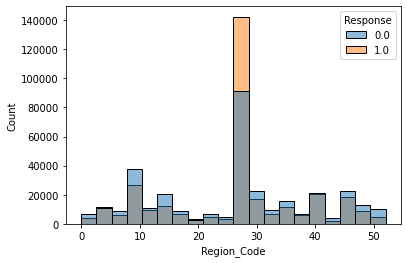

In [65]:
plot_df = combined_df.toPandas()
ax = sns.histplot(x="Region_Code",  hue="Response", data= plot_df, bins= 20)

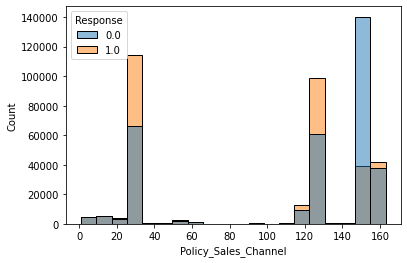

In [66]:
ax = sns.histplot(x="Policy_Sales_Channel",  hue="Response", data= plot_df, bins= 20)

Region code and policy_sales_channel being categorical variable needs to be one_hot_encoded. After looking at the distribution abobe, there is a chance that encoding these two variable can improve results. The cost for doing this will be increasing the dimensionality of the data. Hence compromising on CV and using best hyper parameters values from previous model.

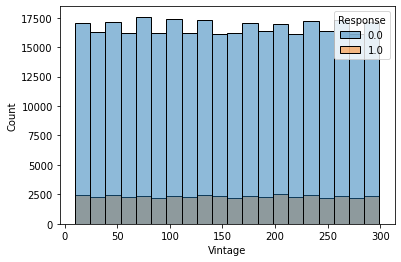

In [69]:
plot_df = train.toPandas()
ax = sns.histplot(x="Vintage",  hue="Response", data= plot_df, bins= 20)

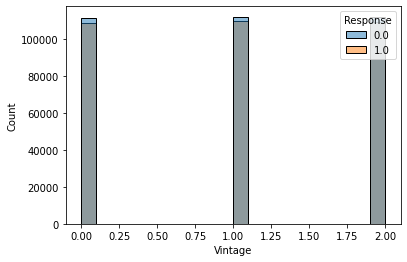

In [70]:
plot_df = combined_df.toPandas()
ax = sns.histplot(x="Vintage",  hue="Response", data= plot_df, bins= 20)

From the above two graphs we can see that the Vintage has equal proportion of Response labels no matter used as it is or binned. Moreover the base model coefficient analysis shows that the variable is insignificant even without oversampling.  Hence dropping vintage in the following feature engineering pipeline. 

In [73]:
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexerModel

gender_si = StringIndexerModel.from_labels(['Male', 'Female'],
                                    inputCol="Gender",
                                    outputCol="indexedGender")

Vehicle_Age_si = StringIndexerModel.from_labels(['< 1 Year','1-2 Year', '> 2 Years'],
                                    inputCol="Vehicle_Age",
                                    outputCol="indexedVehicle_Age")

Vehicle_Damage_si = StringIndexerModel.from_labels(['Yes', 'No'],
                                    inputCol="Vehicle_Damage",
                                    outputCol="indexedVehicle_Damage")

age_bin = feature.Bucketizer(splits=[0, 35, 65, 100], inputCol='Age',outputCol= 'Age_bin')

policy_si = feature.StringIndexer(inputCol='Policy_Sales_Channel', outputCol='policy_col2', handleInvalid='skip')
policy_one_hot = feature.OneHotEncoder(inputCol='policy_col2',outputCol = "One Hot Policy")

region_si = feature.StringIndexer(inputCol='Region_Code', outputCol='region_col2', handleInvalid='skip')
region_one_hot = feature.OneHotEncoder(inputCol='region_col2',outputCol = "One Hot Region")


feature_engineering_pipe = Pipeline(stages=[gender_si,Vehicle_Age_si,Vehicle_Damage_si,age_bin,policy_si,policy_one_hot,region_si,region_one_hot])


train_xformed = feature_engineering_pipe.fit(train).transform(train) \
.drop('Gender','Vehicle_Age','Vehicle_Damage','Vintage','Age','Policy_Sales_Channel','Region_Code','policy_col2','region_col2') \
.withColumnRenamed("indexedGender",'Gender') \
.withColumnRenamed("indexedVehicle_Age",'Vehicle_Age') \
.withColumnRenamed("indexedVehicle_Damage",'Vehicle_Damage') \


train_xformed.show()

+---------------+------------------+--------------+--------+------+-----------+--------------+-------+----------------+---------------+
|Driving_License|Previously_Insured|Annual_Premium|Response|Gender|Vehicle_Age|Vehicle_Damage|Age_bin|  One Hot Policy| One Hot Region|
+---------------+------------------+--------------+--------+------+-----------+--------------+-------+----------------+---------------+
|            1.0|               0.0|       40454.0|     1.0|   0.0|        2.0|           0.0|    1.0| (154,[1],[1.0])| (52,[0],[1.0])|
|            1.0|               0.0|       33536.0|     0.0|   0.0|        1.0|           1.0|    2.0| (154,[1],[1.0])| (52,[8],[1.0])|
|            1.0|               0.0|       38294.0|     1.0|   0.0|        2.0|           0.0|    1.0| (154,[1],[1.0])| (52,[0],[1.0])|
|            1.0|               1.0|       28619.0|     0.0|   0.0|        0.0|           1.0|    0.0| (154,[0],[1.0])| (52,[9],[1.0])|
|            1.0|               1.0|       27496

In [74]:
from pyspark.sql.functions import col, explode, array, lit
major_df = train_xformed.filter(col("Response") == 0)
minor_df = train_xformed.filter(col("Response") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 7


In [75]:
a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
combined_df = major_df.unionAll(oversampled_df)
combined_df.show()

+---------------+------------------+--------------+--------+------+-----------+--------------+-------+----------------+---------------+
|Driving_License|Previously_Insured|Annual_Premium|Response|Gender|Vehicle_Age|Vehicle_Damage|Age_bin|  One Hot Policy| One Hot Region|
+---------------+------------------+--------------+--------+------+-----------+--------------+-------+----------------+---------------+
|            1.0|               0.0|       33536.0|     0.0|   0.0|        1.0|           1.0|    2.0| (154,[1],[1.0])| (52,[8],[1.0])|
|            1.0|               1.0|       28619.0|     0.0|   0.0|        0.0|           1.0|    0.0| (154,[0],[1.0])| (52,[9],[1.0])|
|            1.0|               1.0|       27496.0|     0.0|   1.0|        0.0|           1.0|    0.0| (154,[0],[1.0])| (52,[3],[1.0])|
|            1.0|               0.0|        2630.0|     0.0|   1.0|        0.0|           0.0|    0.0| (154,[3],[1.0])|(52,[11],[1.0])|
|            1.0|               0.0|       23367

In [87]:


lr = classification.LogisticRegression(labelCol='Response', elasticNetParam= 0.0 , regParam= 0.0001)

final_model_pipeline = Pipeline(stages=[feature.VectorAssembler(inputCols= combined_df.drop('Response').columns,outputCol = 'features' ), lr])

train_df, validation_df = combined_df.randomSplit([0.9, 0.1], 42)

initial_model = final_model_pipeline.fit(train_df)

predictions = initial_model.transform(validation_df)

evaluator = evaluation.BinaryClassificationEvaluator(labelCol = 'Response',metricName='areaUnderPR')

print('Validation AreaUnderPR {}'.format(evaluator.evaluate(predictions)))

accuracy = predictions.filter(predictions.Response == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)



Validation AreaUnderPR 0.7703933548654011
Accuracy :  0.7973258481226608


In [99]:
lrm = initial_model.stages[-1]
transformed =  initial_model.transform(train_df)
from itertools import chain

attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*transformed
        .schema[lrm.summary.featuresCol]
        .metadata["ml_attr"]["attrs"].values())))


data = [(name, abs(lrm.coefficients[idx])) for idx, name in attrs]

df = pd.DataFrame(data, columns =['Feature', 'Coefficient'])
display(df)

,Feature,Coefficient
0,Driving_License,1.243936e+00
1,Previously_Insured,3.916550e+00
2,Annual_Premium,3.209281e-07
3,Gender,7.079463e-02
4,Vehicle_Age,2.576100e-01
...,...,...
208,One Hot Region_5.0,1.346529e-01
209,One Hot Region_1.0,6.651124e-01
210,One Hot Region_44.0,8.036634e-01
211,One Hot Region_42.0,6.752706e-01


In [100]:
df = df.sort_values('Coefficient', ascending=False)

In [101]:
display(df)

,Feature,Coefficient
158,One Hot Policy_149.0,8.492429e+00
138,One Hot Policy_67.0,8.305405e+00
154,One Hot Policy_75.0,8.247993e+00
131,One Hot Policy_79.0,8.182243e+00
149,One Hot Policy_34.0,8.164929e+00
...,...,...
45,One Hot Policy_10.0,1.485547e-02
37,One Hot Policy_16.0,1.349588e-02
161,One Hot Region_28.0,1.141344e-02
180,One Hot Region_14.0,3.919189e-03


In [106]:
df.head(10)

,Feature,Coefficient
158,One Hot Policy_149.0,8.492429
138,One Hot Policy_67.0,8.305405
154,One Hot Policy_75.0,8.247993
131,One Hot Policy_79.0,8.182243
149,One Hot Policy_34.0,8.164929
152,One Hot Policy_50.0,8.129195
140,One Hot Policy_70.0,8.025669
151,One Hot Policy_112.0,8.006215
148,One Hot Policy_33.0,7.932418
107,One Hot Policy_46.0,7.787798


**Conclusion from Logistic regression modeling**
1. Oversampling decreased the accuracy obviously but increased the area under PR but the model can be said to be well generalised. 
2. Encoding region sales and policy variables increased the accuracy by 1%. 
3. Feature importance shows that the policy that customer has is very important in predicting if the customer will buy the vehicle insuarance or not. 
